# 🎯 Parkinson's Disease Detection from Voice
## Domain Adaptation Pipeline

Implementación del paper "Towards a Corpus (and Language)-Independent Screening of Parkinson's Disease from Voice and Speech through Domain Adaptation"

### 📋 Pipeline:
1. **Setup**: Configuración del entorno (Colab/Local)
2. **Data Loading**: Carga de archivos de audio de vocales (.egg)
3. **Preprocessing**: Preprocesamiento según paper (44.1kHz, ventanas 400ms, Mel spectrograms 65×41)
4. **Dataset Creation**: Generación de tensores PyTorch listos para entrenamiento
5. **Visualization**: Análisis visual de señales y espectrogramas
6. **Training**: Entrenamiento de modelos CNN con domain adaptation
7. **Evaluation**: Evaluación del rendimiento

### ⚙️ Características:
- ✅ Preprocesamiento exacto del paper
- ✅ Modular y reutilizable (dataclasses, type hints)
- ✅ Reproducible (dominios determinísticos)
- ✅ Compatible: Local & Google Colab
- ✅ PyTorch-ready: Dataset wrapper incluido


In [1]:
# Instalación de dependencias (solo necesario en Colab)
import sys
import os

# Detectar si estamos en Colab
try:
    import google.colab
    IN_COLAB = True
    print("🚀 Ejecutando en Google Colab")
except ImportError:
    IN_COLAB = False
    print("💻 Ejecutando localmente")

# Instalar dependencias si estamos en Colab
if IN_COLAB:
    %pip install librosa soundfile scikit-learn matplotlib seaborn pandas numpy
    %pip install torch torchvision torchaudio tqdm
    # Montar Google Drive si es necesario
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Asegúrate de tener instaladas las siguientes librerías:")
    print("- librosa, soundfile, scikit-learn")
    print("- matplotlib, seaborn, pandas, numpy")
    print("- torch, torchvision, torchaudio (FRAMEWORK PRINCIPAL)")
    print("- tqdm (para barras de progreso)")
    
    # Instalar tqdm si no está disponible
    try:
        from tqdm import tqdm
        print("✅ tqdm ya está instalado")
    except ImportError:
        print("⚠️ Instalando tqdm...")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "tqdm"])
        from tqdm import tqdm
        print("✅ tqdm instalado correctamente")


💻 Ejecutando localmente
Asegúrate de tener instaladas las siguientes librerías:
- librosa, soundfile, scikit-learn
- matplotlib, seaborn, pandas, numpy
- torch, torchvision, torchaudio (FRAMEWORK PRINCIPAL)
- tqdm (para barras de progreso)
✅ tqdm ya está instalado


In [2]:
# ============================================================
# IMPORTS Y CONFIGURACIÓN
# ============================================================
import sys
from pathlib import Path

# Agregar módulos al path
sys.path.insert(0, str(Path.cwd()))

# Importar MÓDULOS PROPIOS (código modular reutilizable)
from modules import preprocessing, augmentation, dataset, utils, visualization
from modules.preprocessing import (
    SAMPLE_RATE, WINDOW_MS, OVERLAP, N_MELS, HOP_MS,
    FFT_WINDOW_A, FFT_WINDOW_OTHER, TARGET_FRAMES,
    get_preprocessing_config, print_preprocessing_config
)
from modules.dataset import (
    SampleMeta, VowelSegmentsDataset, build_full_pipeline
)
from modules.visualization import (
    visualize_audio_and_spectrograms,
    plot_label_distribution,
    plot_spectrogram_comparison
)

# Librerías estándar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio, display
import random
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configuración de PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reporte de configuración
print(f"✅ Librerías y módulos cargados correctamente")
print(f"🔧 Dispositivo: {device}")
print(f"📦 PyTorch: {torch.__version__}")
print(f"📦 Librosa: {librosa.__version__}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")

# Mostrar configuración de preprocesamiento
print("\n" + "="*60)
print_preprocessing_config()
print("="*60)
print("\n📦 Módulos importados:")
print("   ✓ preprocessing  - Funciones de preprocesamiento")
print("   ✓ augmentation   - Técnicas de data augmentation")
print("   ✓ dataset        - Pipeline de dataset PyTorch")
print("   ✓ utils          - Utilidades comunes")
print("   ✓ visualization  - Gráficas y visualizaciones")


✅ Librerías y módulos cargados correctamente
🔧 Dispositivo: cpu
📦 PyTorch: 2.8.0+cpu
📦 Librosa: 0.11.0

⚙️ Preprocessing Configuration:
  • SAMPLE_RATE: 44100
  • WINDOW_MS: 400
  • OVERLAP: 0.5
  • N_MELS: 65
  • HOP_MS: 10
  • FFT_WINDOW_A: 40
  • FFT_WINDOW_OTHER: 25
  • TARGET_FRAMES: 41

📦 Módulos importados:
   ✓ preprocessing  - Funciones de preprocesamiento
   ✓ augmentation   - Técnicas de data augmentation
   ✓ dataset        - Pipeline de dataset PyTorch
   ✓ utils          - Utilidades comunes
   ✓ visualization  - Gráficas y visualizaciones


## 📁 1. Data Loading

Configuración de rutas y exploración del dataset de vocales.


In [3]:
# Configuración de rutas de datos
if IN_COLAB:
    # En Colab, asumimos que los datos están en Google Drive
    DATA_PATH = "/content/drive/MyDrive/parkinson-voice-uncertainty/vowels"
else:
    # Localmente, usar la ruta relativa
    DATA_PATH = "./vowels"

# Verificar que la ruta existe
if os.path.exists(DATA_PATH):
    print(f"✅ Directorio de datos encontrado: {DATA_PATH}")
    
    # Listar archivos disponibles
    audio_files = list(Path(DATA_PATH).glob("*.egg"))
    nsp_files = list(Path(DATA_PATH).glob("*.nsp"))
    
    print(f"📁 Archivos de audio (.egg): {len(audio_files)}")
    print(f"📁 Archivos de metadatos (.nsp): {len(nsp_files)}")
    
    # Mostrar algunos ejemplos
    print("\n🔍 Primeros 5 archivos de audio:")
    for i, file in enumerate(audio_files[:5]):
        print(f"  {i+1}. {file.name}")
        
else:
    print(f"❌ No se encontró el directorio: {DATA_PATH}")
    print("Asegúrate de que los datos estén en la ubicación correcta")


✅ Directorio de datos encontrado: ./vowels
📁 Archivos de audio (.egg): 13
📁 Archivos de metadatos (.nsp): 13

🔍 Primeros 5 archivos de audio:
  1. 1580-a_h-egg.egg
  2. 1580-a_l-egg.egg
  3. 1580-a_lhl-egg.egg
  4. 1580-a_n-egg.egg
  5. 1580-iau-egg.egg


## 🎵 2. Audio Preprocessing Functions

Funciones de preprocesamiento según paper:
- **Resampling**: 44.1 kHz
- **Segmentation**: Ventanas de 400ms con 50% overlap
- **Mel Spectrograms**: 65 bandas Mel, hop 10ms
- **FFT Windows**: 40ms para /a/, 25ms para otras vocales
- **Normalization**: z-score


In [4]:
# ============================================================
# DATASET PIPELINE → modules/dataset.py
# ============================================================
# ✅ Todo el código del pipeline ha sido movido a módulos reutilizables
#
# Módulo dataset.py contiene:
#   • SampleMeta (dataclass)
#   • VowelSegmentsDataset (PyTorch Dataset)
#   • build_full_pipeline() → Función principal
#   • process_dataset(), to_pytorch_tensors(), etc.

print("📦 Ejecutando pipeline desde modules/dataset.py...")
print("="*60)

# ==============================
# EJECUTAR PIPELINE COMPLETO
# ==============================
try:
    # Llamar al pipeline usando la función importada del módulo
    results = build_full_pipeline(
        audio_files=audio_files,
        preprocess_fn=None,  # Usa preprocessing.preprocess_audio_paper por defecto
        max_files=None       # None = procesar todos los archivos
    )
    
    # Extraer resultados
    dataset = results["dataset"]
    complete_dataset = results["dataset"]  # Alias para compatibilidad
    (X_torch_complete, y_task_torch_complete, y_domain_torch_complete) = results["tensors"]
    metadata_complete = results["metadata"]
    torch_dataset = results["torch_ds"]
    
    print(f"\n🎉 Pipeline completado exitosamente!")
    print(f"   • dataset: {len(dataset)} muestras")
    print(f"   • complete_dataset: alias de dataset")
    print(f"   • X_torch_complete: {X_torch_complete.shape if X_torch_complete is not None else 'None'}")
    print(f"   • torch_dataset: VowelSegmentsDataset con {len(torch_dataset) if torch_dataset else 0} muestras")
    
except NameError as e:
    print(f"❌ Error: {e}")
    print("   Asegúrate de ejecutar las celdas anteriores (especialmente Celda 4)")
    
    # Variables vacías para evitar errores en celdas posteriores
    dataset = []
    complete_dataset = []
    X_torch_complete = y_task_torch_complete = y_domain_torch_complete = None
    metadata_complete = []
    torch_dataset = None


📦 Ejecutando pipeline desde modules/dataset.py...
🔄 Procesando 13 archivos...
  1/13: 1580-a_h-egg.egg
  11/13: 1580-u_l-egg.egg
✅ 121 muestras generadas
📊 PyTorch tensors listos:
  - X: (121, 1, 65, 41)
  - y_task: (121,)  (dist={0: 121})
  - y_domain: (121,)  (K dominios=13)

📊 DISTRIBUCIÓN POR VOCAL:
  - a_h: 1 muestras
  - a_l: 2 muestras
  - a_lhl: 3 muestras
  - a_n: 2 muestras
  - iau: 97 muestras
  - i_h: 2 muestras
  - i_l: 2 muestras
  - i_lhl: 3 muestras
  - i_n: 3 muestras
  - u_h: 1 muestras
  - u_l: 1 muestras
  - u_lhl: 3 muestras
  - u_n: 1 muestras

📊 DISTRIBUCIÓN POR CONDICIÓN:
  - egg: 121 muestras

✅ Dataset COMPLETO listo para entrenamiento con PyTorch!
  - Muestras totales: 121
  - Dimensiones de entrada: (121, 1, 65, 41)
  - Ideal para CNN 2D

🎉 Pipeline completado exitosamente!
   • dataset: 121 muestras
   • complete_dataset: alias de dataset
   • X_torch_complete: torch.Size([121, 1, 65, 41])
   • torch_dataset: VowelSegmentsDataset con 121 muestras


In [5]:
# ============================================================
# DATASET VERIFICATION
# ============================================================

# Verificación rápida
if complete_dataset and X_torch_complete is not None:
    N, C, H, W = X_torch_complete.shape
    task_dist = torch.bincount(y_task_torch_complete)
    
    print("✅ Dataset procesado correctamente")
    print(f"   📊 {N} muestras | {C}×{H}×{W} | {len(torch.unique(y_domain_torch_complete))} dominios")
    print(f"   Control: {task_dist[0]} | Parkinson: {task_dist[1] if len(task_dist) > 1 else 0}")
else:
    print("⚠️ Dataset vacío. Ejecuta Celda 6 primero.")


✅ Dataset procesado correctamente
   📊 121 muestras | 1×65×41 | 13 dominios
   Control: 121 | Parkinson: 0


In [6]:
# ============================================================
# INFO DATASET Y CONFIGURACIÓN
# ============================================================
# Las constantes están en modules/preprocessing.py (ya importadas)
# CONFIG disponible via: preprocessing.SAMPLE_RATE, preprocessing.N_MELS, etc.

print("📊 DATASET LISTO PARA ENTRENAR:")
print(f"   Tensores: X={X_torch_complete.shape}, y_task={y_task_torch_complete.shape}")
print(f"   Configuración: {SAMPLE_RATE}Hz, {N_MELS} mels, {TARGET_FRAMES} frames")
print(f"\n💡 Usa: torch_dataset para DataLoader de PyTorch")


📊 DATASET LISTO PARA ENTRENAR:
   Tensores: X=torch.Size([121, 1, 65, 41]), y_task=torch.Size([121])
   Configuración: 44100Hz, 65 mels, 41 frames

💡 Usa: torch_dataset para DataLoader de PyTorch


In [7]:
# ============================================================
# EJEMPLOS DE METADATA (opcional)
# ============================================================

# Ver algunos ejemplos de metadatos si quieres explorar más
print("📋 Ejemplos de metadatos:")
for i, m in enumerate(metadata_complete[:3]):
    print(f"   {i+1}. {m.filename[:20]} → {m.vowel_type} ({m.condition})")


📋 Ejemplos de metadatos:
   1. 1580-a_h-egg.egg → a_h (egg)
   2. 1580-a_l-egg.egg → a_l (egg)
   3. 1580-a_l-egg.egg → a_l (egg)


📦 Usando módulo: modules/visualization.py
🎨 Visualizando audio original vs espectrogramas procesados...



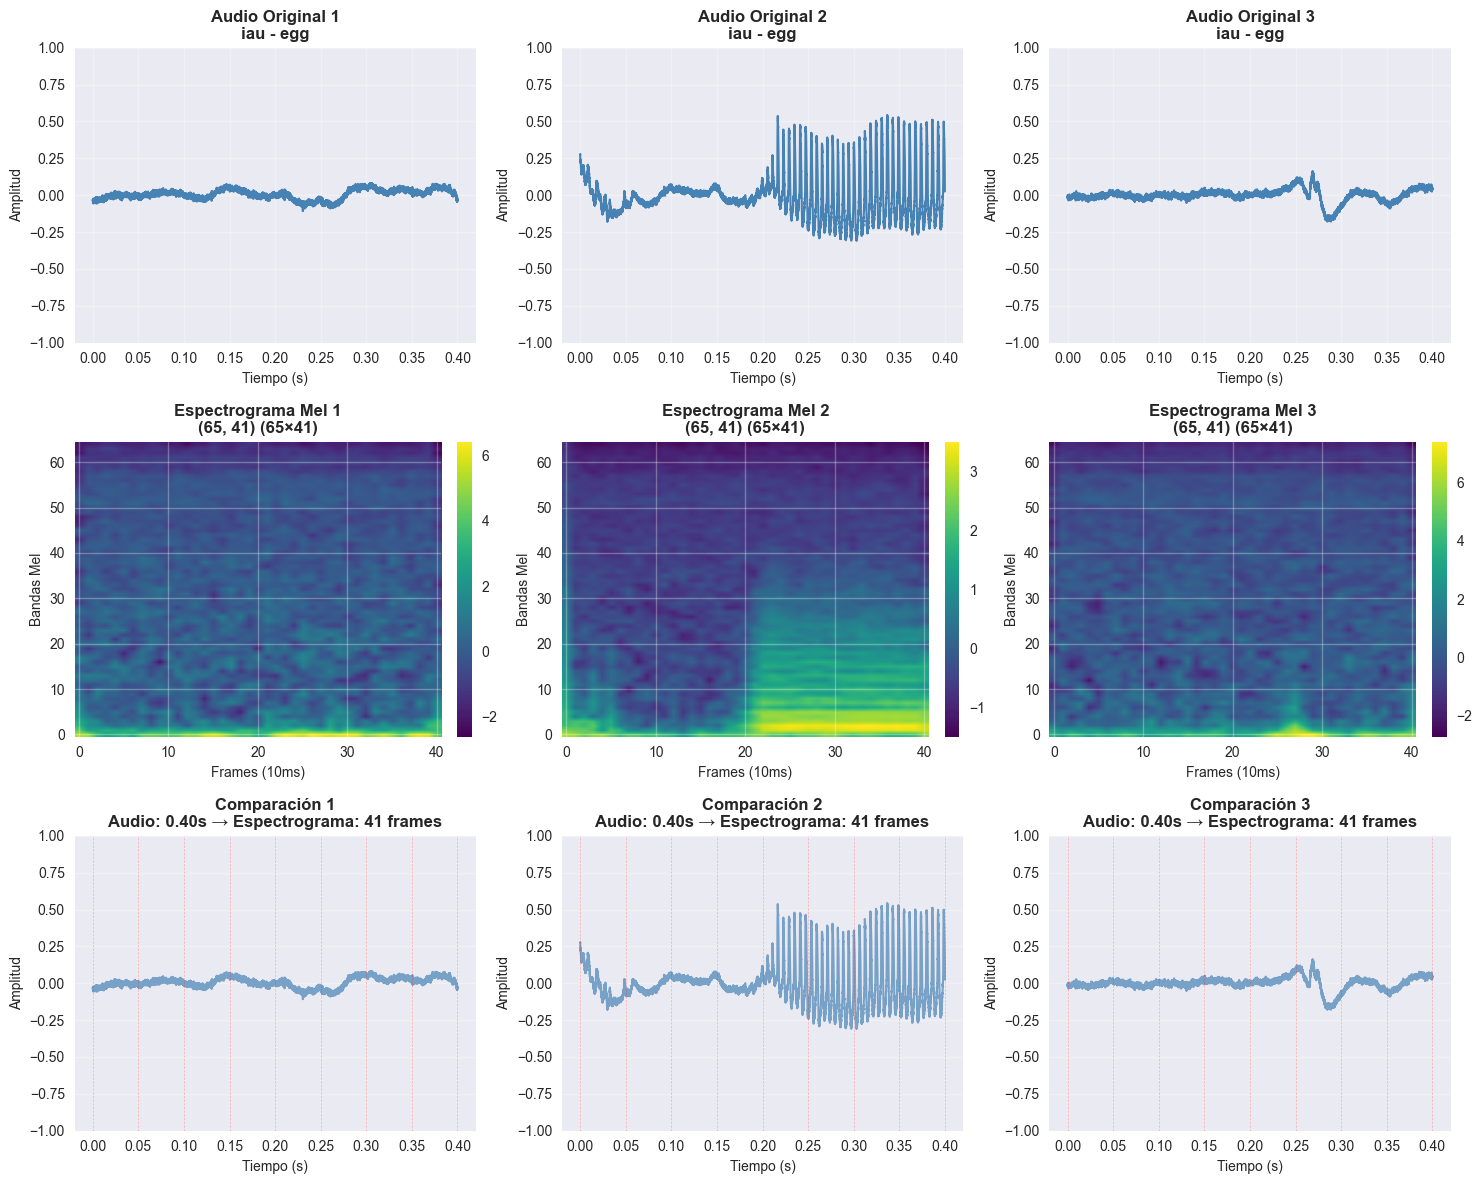


🔊 Reproduciendo audios:
  1. 1580-iau-egg.egg - iau - egg


  2. 1580-iau-egg.egg - iau - egg


  3. 1580-iau-egg.egg - iau - egg



📊 INFORMACIÓN DEL PROCESAMIENTO:
  - Audio original: 0.40s (400ms por segmento)
  - Espectrograma: 65×41 (65 bandas × 41 frames)
  - Frames temporales: 41 (cada 10ms)
  - Ventana FFT: 25ms para vocal iau
  - Normalización: z-score aplicada

✅ Visualización completada exitosamente
💡 Variables generadas:
   • fig: Figura de matplotlib (audio + espectrogramas)
   • audios: Lista de objetos Audio con metadatos
   • fig_dist: Figura de distribución de etiquetas


In [8]:
# ============================================================
# VISUALIZACIÓN → modules/visualization.py
# ============================================================
# ✅ La función de visualización ahora se importa desde el módulo
# ✅ Esto permite reutilizarla en otros notebooks y retorna las figuras

print("📦 Usando módulo: modules/visualization.py")
print("="*60)

# Visualizar dataset procesado usando función del módulo
try:
    if complete_dataset:
        print("🎨 Visualizando audio original vs espectrogramas procesados...\n")
        
        # Llamar función del módulo (retorna fig y audios para control total)
        fig, audios = visualize_audio_and_spectrograms(
            complete_dataset,
            num_samples=3,
            sr=SAMPLE_RATE,
            show=True,
            play_audio=True
        )
        
        # También visualizar distribución de etiquetas
        # if X_torch_complete is not None:
        #     print("\n" + "="*60)
        #     print("📊 Visualización de Distribución de Etiquetas:\n")
            
        #     fig_dist = plot_label_distribution(
        #         y_task_torch_complete,
        #         y_domain_torch_complete,
        #         task_labels=['Control', 'Parkinson'],
        #         show=True
        #     )
            
        print("\n" + "="*60)
        print("✅ Visualización completada exitosamente")
        print("💡 Variables generadas:")
        print("   • fig: Figura de matplotlib (audio + espectrogramas)")
        print("   • audios: Lista de objetos Audio con metadatos")
        print("   • fig_dist: Figura de distribución de etiquetas")
    else:
        print("⚠️ complete_dataset está vacío.")
        print("   Ejecuta las celdas anteriores primero (especialmente Celda 7)")
        
except NameError as e:
    print(f"⚠️ Error: {e}")
    print("   Ejecuta las celdas anteriores primero para procesar el dataset")


In [9]:
# ============================================================
# DATA AUGMENTATION - LAS 3 TÉCNICAS (OPTIMIZADO)
# ============================================================
from modules.augmentation import preprocess_audio_with_augmentation
from modules.dataset import parse_filename

print("🎵 DATA AUGMENTATION - LAS 3 TÉCNICAS")
print("="*60)
print("Pipeline: Audio completo → Augment → Segment → Mel → Normalize\n")

# Archivo de ejemplo
example_file = audio_files[0]
subject_id, vowel_type, condition = parse_filename(example_file.stem)
print(f"🎯 Archivo: {example_file.name} | Vocal: {vowel_type} | Condición: {condition}\n")

# Configuración de augmentations (elimina duplicación)
AUG_DEMOS = {
    "original": {
        "title": "AUDIO ORIGINAL",
        "params_list": [(None, "")],
        "lib": ""
    },
    "pitch_shift": {
        "title": "PITCH SHIFTING (cambiar tono)",
        "params_list": [
            ({"n_steps": n}, f"{n:+2d} semitonos {'↑' if n > 0 else '↓'}") 
            for n in [-2, -1, 1, 2]
        ],
        "lib": "librosa.effects.pitch_shift(y, sr, n_steps=±2)"
    },
    "time_stretch": {
        "title": "TIME STRETCHING (cambiar velocidad)",
        "params_list": [
            ({"rate": r}, f"{r:.1f}x {'rápido' if r > 1.0 else 'lento'}") 
            for r in [0.9, 1.1]
        ],
        "lib": "librosa.effects.time_stretch(y, rate=1.1)"
    },
    "noise": {
        "title": "RUIDO ADITIVO (≈30 dB SNR)",
        "params_list": [({"noise_factor": 0.005}, "0.005")],
        "lib": "y + 0.005 * np.random.randn(len(y))"
    }
}

# Aplicar todas las augmentations (loop unificado)
results = {}
for idx, (aug_type, config) in enumerate(AUG_DEMOS.items(), 1):
    print(f"📌 {idx}. {config['title']}")
    if config['lib']:
        print(f"   {config['lib']}")
    
    results[aug_type] = {}
    for params, desc in config['params_list']:
        specs, segs, label = preprocess_audio_with_augmentation(
            example_file, vowel_type=vowel_type,
            aug_type=aug_type, aug_params=params
        )
        results[aug_type][str(params or '')] = {
            "specs": specs, "segs": segs, "label": label
        }
        print(f"   ✓ {desc or 'sin augment'}: {len(segs)} segs → '{label}'")
    print()

# Resumen compacto
total = sum(len(v) for v in results.values())
print(f"✅ RESUMEN: {total} versiones | {len(audio_files)} archivos × {total} = {len(audio_files) * total} total")
print(f"💡 Variables: results['pitch_shift'], results['time_stretch'], results['noise'], results['original']")


🎵 DATA AUGMENTATION - LAS 3 TÉCNICAS
Pipeline: Audio completo → Augment → Segment → Mel → Normalize

🎯 Archivo: 1580-a_h-egg.egg | Vocal: a_h | Condición: egg

📌 1. AUDIO ORIGINAL
   ✓ sin augment: 1 segs → 'original'

📌 2. PITCH SHIFTING (cambiar tono)
   librosa.effects.pitch_shift(y, sr, n_steps=±2)
   ✓ -2 semitonos ↓: 1 segs → 'pitch_-2'
   ✓ -1 semitonos ↓: 1 segs → 'pitch_-1'
   ✓ +1 semitonos ↑: 1 segs → 'pitch_+1'
   ✓ +2 semitonos ↑: 1 segs → 'pitch_+2'

📌 3. TIME STRETCHING (cambiar velocidad)
   librosa.effects.time_stretch(y, rate=1.1)
   ✓ 0.9x lento: 2 segs → 'time_0.90x'
   ✓ 1.1x rápido: 1 segs → 'time_1.10x'

📌 4. RUIDO ADITIVO (≈30 dB SNR)
   y + 0.005 * np.random.randn(len(y))
   ✓ 0.005: 1 segs → 'noise_0.0050'

✅ RESUMEN: 8 versiones | 13 archivos × 8 = 104 total
💡 Variables: results['pitch_shift'], results['time_stretch'], results['noise'], results['original']


✨ SPECAUGMENT - Máscaras de Frecuencia y Tiempo
Diferencia: Audio augment → ANTES de segmentar | SpecAugment → DESPUÉS de Mel

📌 SIN SpecAugment: 1 specs → 'original'
📌 CON SpecAugment: 1 specs → 'spec_aug'
📌 Pitch+SpecAugment: 1 specs → 'pitch_+2_spec_aug'


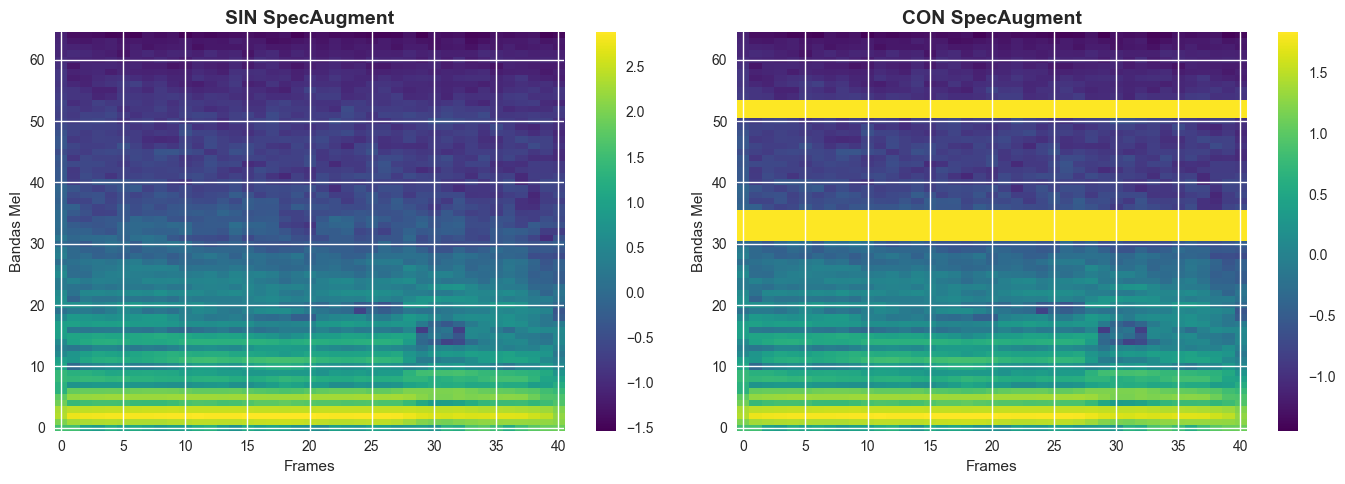


💡 Observa las máscaras (regiones oscuras) en el espectrograma derecho


In [10]:
# ============================================================
# SPECAUGMENT - AUGMENTATION SOBRE ESPECTROGRAMA (OPTIMIZADO)
# ============================================================
import matplotlib.pyplot as plt

print("✨ SPECAUGMENT - Máscaras de Frecuencia y Tiempo")
print("="*60)
print("Diferencia: Audio augment → ANTES de segmentar | SpecAugment → DESPUÉS de Mel\n")

# Configuración SpecAugment
SPEC_AUG_PARAMS = {"freq_mask_param": 10, "time_mask_param": 5, 
                   "num_freq_masks": 2, "num_time_masks": 2}

# Comparación: SIN vs CON SpecAugment
configs = [
    ("SIN SpecAugment", False, None),
    ("CON SpecAugment", True, SPEC_AUG_PARAMS),
    ("Pitch+SpecAugment", True, SPEC_AUG_PARAMS)  # Combinado
]

specs_comparison = {}
for title, apply_spec, params in configs:
    aug_type = "pitch_shift" if "Pitch" in title else "original"
    aug_params = {"n_steps": 2} if "Pitch" in title else None
    
    specs, segs, label = preprocess_audio_with_augmentation(
        example_file, vowel_type=vowel_type,
        aug_type=aug_type, aug_params=aug_params,
        apply_spec_augment=apply_spec, spec_augment_params=params
    )
    specs_comparison[title] = (specs, label)
    print(f"📌 {title}: {len(specs)} specs → '{label}'")

# Visualización compacta (primeros 2)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
titles = list(specs_comparison.keys())[:2]

for idx, (ax, title) in enumerate(zip(axes, titles)):
    spec = specs_comparison[title][0][0]
    im = ax.imshow(spec, aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Frames'); ax.set_ylabel('Bandas Mel')
    plt.colorbar(im, ax=ax)

plt.tight_layout(); plt.show()
print("\n💡 Observa las máscaras (regiones oscuras) en el espectrograma derecho")


In [11]:
# ============================================================
# DATASET AUGMENTADO COMPLETO
# ============================================================
from modules.augmentation import create_augmented_dataset
import pandas as pd
from collections import Counter

# Configuración
APPLY_AUGMENTATION = True  # ⚠️ True para ejecutar
APPLY_SPEC_AUGMENT = True  # ⚠️ True para SpecAugment
AUGMENTATION_TYPES = ["original", "pitch_shift", "time_stretch", "noise"]

if APPLY_AUGMENTATION:
    # Ejecutar
    augmented_dataset = create_augmented_dataset(
        audio_files, AUGMENTATION_TYPES, APPLY_SPEC_AUGMENT, progress_every=3
    )
    from modules.dataset import to_pytorch_tensors
    X_aug, y_task_aug, y_domain_aug, meta_aug = to_pytorch_tensors(augmented_dataset)
    
    # Tabla de resultados
    aug_dist = Counter([s.get('augmentation', 'unknown') for s in augmented_dataset])
    
    print("\n📊 RESULTADOS:")
    print(pd.DataFrame([
        {"Métrica": "Original", "Valor": len(complete_dataset)},
        {"Métrica": "Augmentado", "Valor": len(augmented_dataset)},
        {"Métrica": "Factor", "Valor": f"{len(augmented_dataset)/len(complete_dataset):.1f}x"},
        {"Métrica": "Shape", "Valor": str(X_aug.shape)},
    ]).to_string(index=False))
    
    print("\n📋 DISTRIBUCIÓN:")
    print(pd.DataFrame([
        {"Técnica": k, "N": v, "%": f"{100*v/len(augmented_dataset):.1f}"}
        for k, v in sorted(aug_dist.items())
    ]).to_string(index=False))
    
else:
    # Estimación
    n = len(audio_files)
    print("\n📊 ESTIMACIÓN:")
    print(pd.DataFrame([
        {"": "Archivos", "Valor": n},
        {"": "Versiones", "Valor": n * 8},
        {"": "Segmentos (~)", "Valor": n * 80},
        {"": "Tiempo (~min)", "Valor": f"{n * 0.5:.1f}"},
    ]).to_string(index=False))
    print("\n⏭️  Cambia APPLY_AUGMENTATION = True")


🎨 Creando dataset con augmentation...
   Archivos: 13 | Tipos: ['original', 'pitch_shift']...
   ✨ SpecAugment: ACTIVADO
  1/13: 1580-a_h-egg.egg
  4/13: 1580-a_n-egg.egg
  7/13: 1580-i_l-egg.egg
  10/13: 1580-u_h-egg.egg
  13/13: 1580-u_n-egg.egg

✅ Dataset: 977 muestras totales
📊 PyTorch tensors listos:
  - X: (977, 1, 65, 41)
  - y_task: (977,)  (dist={0: 977})
  - y_domain: (977,)  (K dominios=13)

📊 RESULTADOS:
   Métrica                        Valor
  Original                          121
Augmentado                          977
    Factor                         8.1x
     Shape torch.Size([977, 1, 65, 41])

📋 DISTRIBUCIÓN:
                                                                                                                                                                                                                                                                                                                                                                           